## COMP 4432 - Assignment 3

Authored by: Zachary Francis

### Part 1: Data Exploration

Load the titanic dataset from Seaborn and document the columns that are missing data both numerically and visually.

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

titanic = sns.load_dataset('titanic')
print("Shape: ", titanic.shape)
print("Row count by column:")
print(titanic.count())

Shape:  (891, 15)
Row count by column:
survived       891
pclass         891
sex            891
age            714
sibsp          891
parch          891
fare           891
embarked       889
class          891
who            891
adult_male     891
deck           203
embark_town    889
alive          891
alone          891
dtype: int64


The titanic dataset has 891 instances over 15 features.  By count, the columms missing data are `age`, `embarked`, `deck`, and `embark_town`.  The heatmap below shows the same, with `deck` and `age` having the most missing values.

<Axes: >

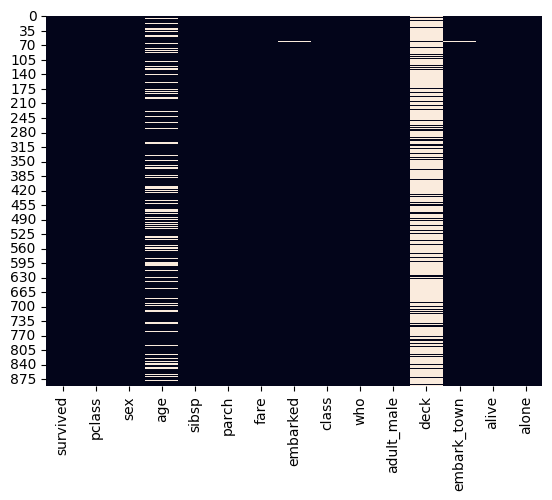

In [2]:
sns.heatmap(titanic.isna(), cbar=False)

In [3]:
numeric_types = ['int64', 'float64']
titanic['survived'] = titanic.survived.astype(bool)
titanic_nums = titanic.select_dtypes(include=numeric_types)
titanic_cats = titanic.select_dtypes(exclude=numeric_types)

The categorical features within the data set are:
* Survived / Alive
* Sex / Adult Male
* Embarked
* Class
* Who
* Deck
* Embark Town
* Alone

**Did more men or women die on the _Titanic_?**

sex     survived
female  True        233
        False        81
male    False       468
        True        109
Name: count, dtype: int64


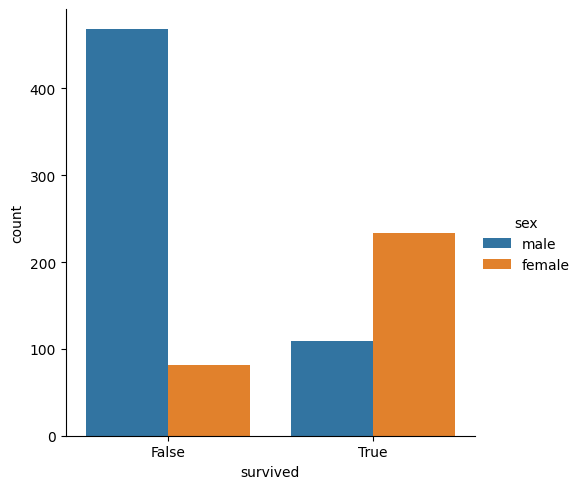

In [4]:
print(titanic.groupby(by='sex', observed=True)['survived'].value_counts())
sns.catplot(kind='count', data=titanic, x='survived', hue='sex')

The above count and plot shows that much more men died than women.

**Which passenger class was more likely to survive?**

Average survival rate by passenger class:
class
First     0.629630
Second    0.472826
Third     0.242363
Name: survived, dtype: float64


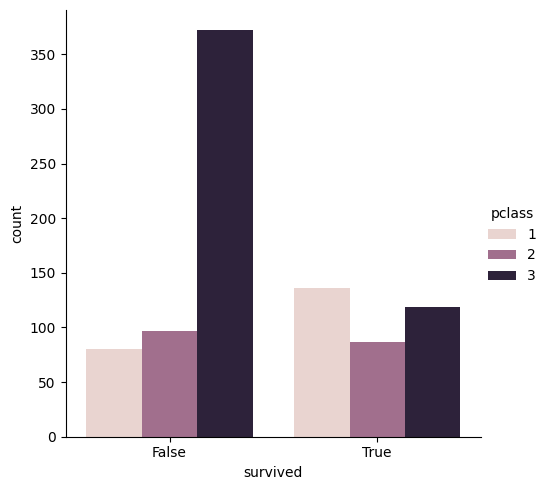

In [5]:
print("Average survival rate by passenger class:")
print(titanic.groupby(by='class', observed=True)['survived'].mean())
sns.catplot(kind='count', data=titanic, x='survived', hue='pclass')

The first class passengers were more likely to survive.  The first class passenger survival rate was about 63%, the only class with a survival rate above 50%.

**What does the distribution of fare look like?**

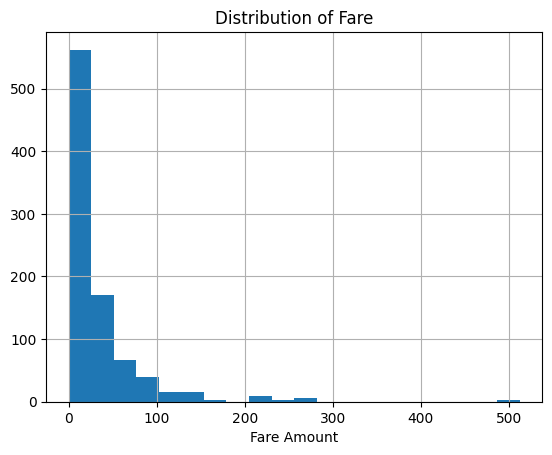

In [6]:
ax = titanic['fare'].hist(bins=20)
ax.set_title('Distribution of Fare')
ax.set_xlabel('Fare Amount')
plt.show()

The fare is a right skewed distribution.

**What does the distribution of non-null age values look like?**

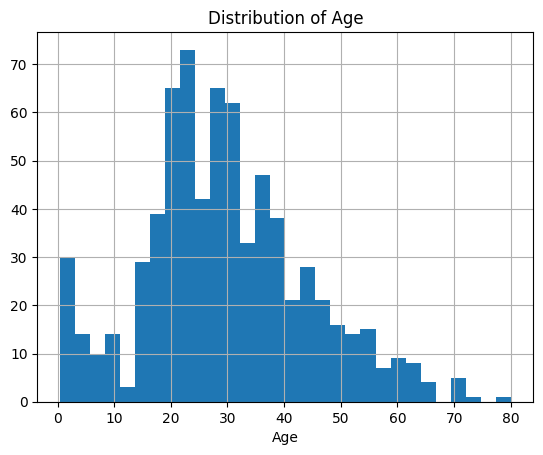

In [7]:
ax = titanic['age'].hist(bins=30)
ax.set_title('Distribution of Age')
ax.set_xlabel('Age')
plt.show()

The age distribution is somewhat normal with a right skew.

**What is the median age of each passenger class?  Visualize this in a box plot**

In [8]:
titanic.groupby(by='class', observed=True)['age'].median()

class
First     37.0
Second    29.0
Third     24.0
Name: age, dtype: float64

<Axes: xlabel='age', ylabel='class'>

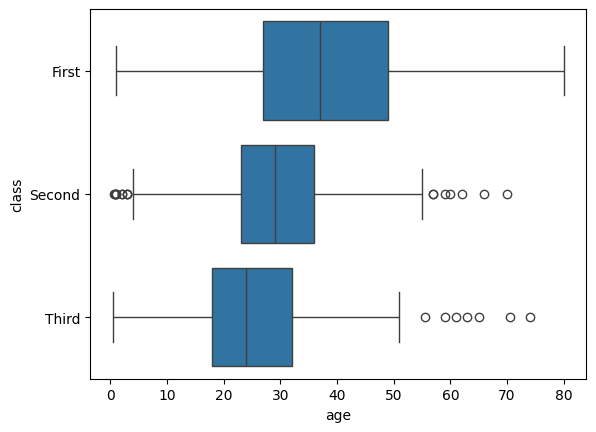

In [9]:
sns.boxplot(titanic, x='age', y='class')

### Part 2: Data Cleansing

Since there are so many missing values in Deck, get rid of the cabin feature.

In [10]:
titanic.drop(columns='deck', inplace=True)

Define a function to impute age using the median of the passenger class you computed
earlier. To call it, use _train[[‘age’, ‘pclass]].apply(impute_age,axis=1)_.

In [11]:
titanic['age'] = titanic.groupby(by='class', observed=True)['age'].transform(
    lambda x: x.fillna(x.median())
)

Drop the remaining records containing null values and show there are no remaining null values.

In [12]:
titanic.dropna(inplace=True)
titanic.isnull().sum()

survived       0
pclass         0
sex            0
age            0
sibsp          0
parch          0
fare           0
embarked       0
class          0
who            0
adult_male     0
embark_town    0
alive          0
alone          0
dtype: int64

The sum output of `isnull` shows there are no more null values in any of the features.

Convert categorical variables to numeric dummies.

In [13]:
# Dropping redundant categories before dummy variable encoding
titanic.drop(columns=['alive','adult_male','class','who'], inplace=True)
titanic = pd.get_dummies(titanic)

Create a feature and target set.

In [14]:
features = titanic.drop(columns='survived')
target = titanic['survived']

Split the data into a training and test set.

In [15]:
from sklearn.model_selection import train_test_split

feature_train, feature_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=4432
)

### Part 3: Model Training

Implement a logistic regression model.

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

log_clf = LogisticRegression(max_iter=1000, random_state=4432)
log_clf.fit(feature_train, target_train)
log_clf_preds = log_clf.predict(feature_train)
print(classification_report(target_train, log_clf_preds))

              precision    recall  f1-score   support

       False       0.83      0.87      0.85       434
        True       0.78      0.71      0.75       277

    accuracy                           0.81       711
   macro avg       0.80      0.79      0.80       711
weighted avg       0.81      0.81      0.81       711



Implement a support vector classifier.

In [17]:
from sklearn.svm import SVC

svc_clf = SVC(probability=True, random_state=4432)
svc_clf.fit(feature_train, target_train)
svc_clf_preds = svc_clf.predict(feature_train)
print(classification_report(target_train, svc_clf_preds))

              precision    recall  f1-score   support

       False       0.67      0.93      0.78       434
        True       0.71      0.29      0.41       277

    accuracy                           0.68       711
   macro avg       0.69      0.61      0.59       711
weighted avg       0.69      0.68      0.64       711



Implement an SGD classifier.

In [18]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=4432)
sgd_clf.fit(feature_train, target_train)
sgd_clf_preds = sgd_clf.predict(feature_train)
print(classification_report(target_train, sgd_clf_preds))

              precision    recall  f1-score   support

       False       0.75      0.83      0.79       434
        True       0.68      0.57      0.62       277

    accuracy                           0.73       711
   macro avg       0.71      0.70      0.70       711
weighted avg       0.72      0.73      0.72       711



Print out the confusion matrix for each classifier.

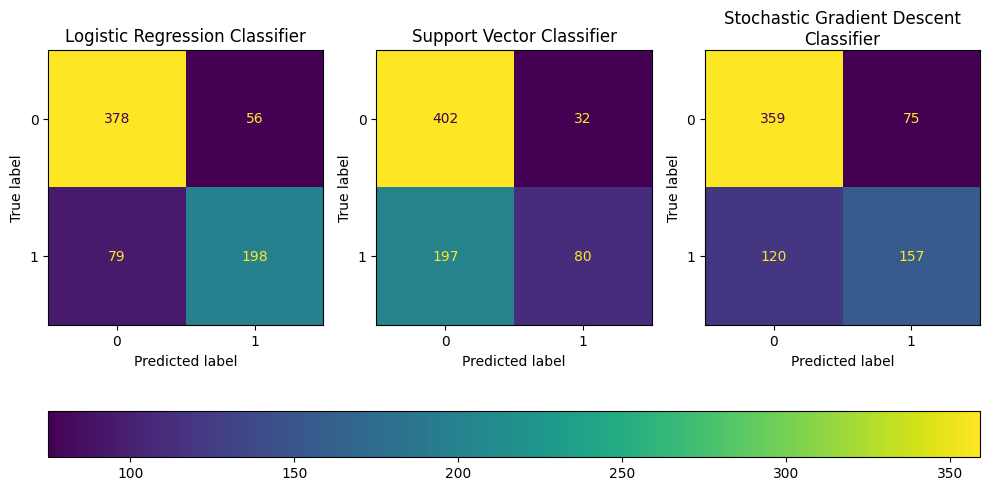

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = {
    "Logistic Regression Classifier": log_clf_preds,
    "Support Vector Classifier": svc_clf_preds,
    "Stochastic Gradient Descent Classifier": sgd_clf_preds
}

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,6))
for idx, (title, preds) in enumerate(predictions.items()):
    cm = confusion_matrix(target_train, preds)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(ax=axs[idx])
    axs[idx].set_title(title, wrap=True)
    disp.im_.colorbar.remove()

fig.tight_layout()
fig.colorbar(disp.im_, ax=axs, location='bottom')
plt.show()

Print out the ROC score and chart for each classifier.

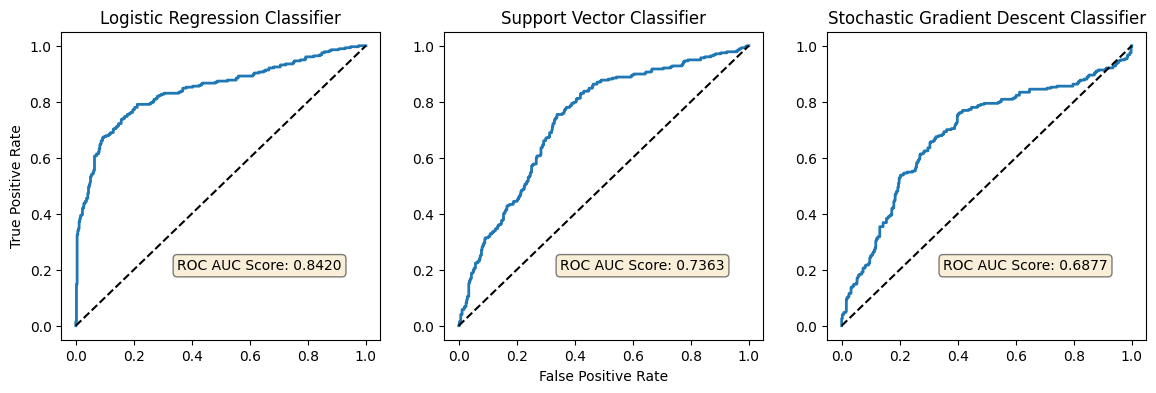

In [20]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_predict

classifiers = {
    "Logistic Regression Classifier": log_clf,
    "Support Vector Classifier": svc_clf,
    "Stochastic Gradient Descent Classifier": sgd_clf
}

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14,4))
for idx, (title, clf) in enumerate(classifiers.items()):
    scores = cross_val_predict(clf, feature_train, target_train, cv=5, method='decision_function')
    fpr, tpr, thresholds = roc_curve(target_train, scores)
    roc = roc_auc_score(target_train, scores)
    axs[idx].plot(fpr, tpr, linewidth=2)
    axs[idx].plot([0, 1], [0, 1], 'k--')
    axs[idx].set_title(title, wrap=True)
    axs[idx].text(0.35, 0.2, f"ROC AUC Score: {roc:.4f}", bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axs[0].set_ylabel('True Positive Rate')
axs[1].set_xlabel('False Positive Rate')
plt.show()


### Part 4: Model Tuning

See if scaling the input data affects the SVC model.  Create a pipeline to combine scaling and instation of the model.

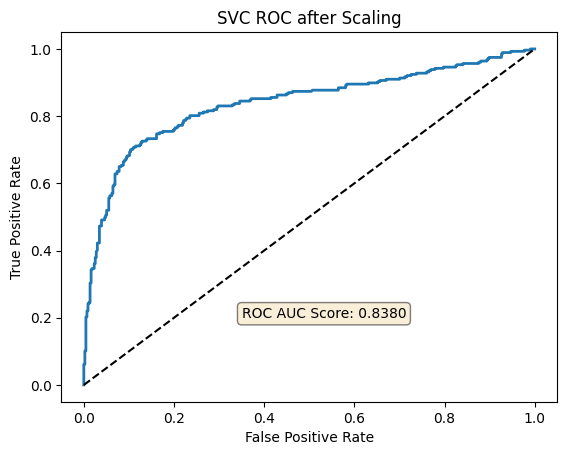

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

svc_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(probability=True, random_state=4432))
])

svc_scaled = svc_pipe.fit(feature_train, target_train)
scores = cross_val_predict(svc_scaled, feature_train, target_train, cv=5, method='decision_function')
fpr, tpr, thresholds = roc_curve(target_train, scores)
roc = roc_auc_score(target_train, scores)
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('SVC ROC after Scaling', wrap=True)
plt.text(0.35, 0.2, f"ROC AUC Score: {roc:.4f}", bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Scaling data improves performance of the Support Vector Classifier, the ROC score jumped from 0.736 to 0.838.  It's worth noting the logistic regression classifier still performs better.

Perform a grid search of pipeline classifier to tune the SVC classifier:

In [22]:
from sklearn.model_selection import GridSearchCV

params = {
    'svc__kernel': ['rbf'],
    'svc__gamma': [0.0001, 0.001, 0.01, 0.1, 1],
    'svc__C': [1, 10, 50, 100, 200, 300]
}

svc_grid = GridSearchCV(svc_pipe, params)
svc_grid.fit(feature_train, target_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svc',
                                        SVC(probability=True,
                                            random_state=4432))]),
             param_grid={'svc__C': [1, 10, 50, 100, 200, 300],
                         'svc__gamma': [0.0001, 0.001, 0.01, 0.1, 1],
                         'svc__kernel': ['rbf']})

Print the best estimator and its parameters and the resulting score.

In [23]:
print("Best estimator for the SVC pipeline:")
print(svc_grid.best_estimator_)

Best estimator for the SVC pipeline:
Pipeline(steps=[('scaler', StandardScaler()),
                ('svc',
                 SVC(C=10, gamma=0.01, probability=True, random_state=4432))])


In [24]:
print("Parameters of the best estimator:")
print(svc_grid.best_params_)

Parameters of the best estimator:
{'svc__C': 10, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


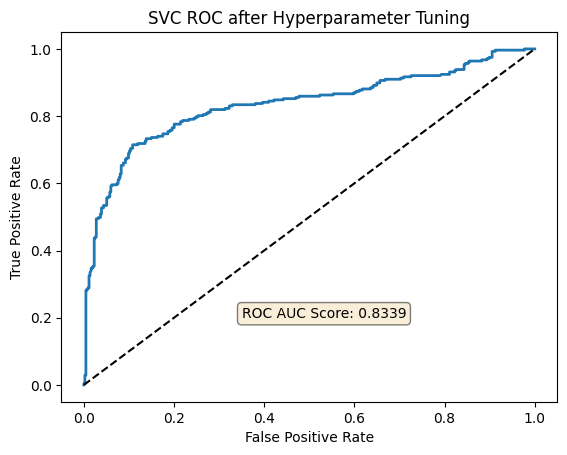

In [25]:
svc_best = svc_grid.best_estimator_
scores = cross_val_predict(svc_best, feature_train, target_train, cv=5, method='decision_function')
fpr, tpr, thresholds = roc_curve(target_train, scores)
roc = roc_auc_score(target_train, scores)
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('SVC ROC after Hyperparameter Tuning', wrap=True)
plt.text(0.35, 0.2, f"ROC AUC Score: {roc:.4f}", bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The tuned model does not perform any better that the deafult parameters on the SVC pipeline model.

Implement a learning curve using the best estimator from the grid search.

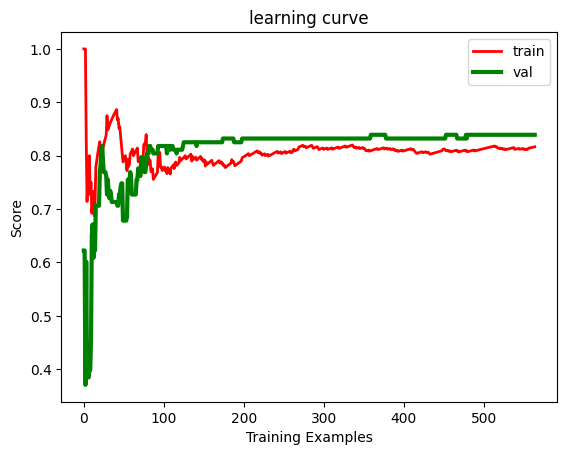

In [26]:
def plot_learning_curve(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=4432)
    train_scores, val_scores = [], []
    for m in range(3, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        train_scores.append(model.score(X_train[:m], y_train[:m]))
        val_scores.append(model.score(X_val, y_val))
    plt.plot(train_scores, 'r-', linewidth=2, label='train')
    plt.plot(val_scores, 'g-', linewidth=3, label='val')
    plt.title("learning curve")
    plt.ylabel("Score")
    plt.xlabel("Training Examples")
    plt.legend()

plot_learning_curve(svc_best, feature_train, target_train)
plt.show()

The learning curve shows that the model only needed around 100 or so training examples to acheive it's highest score on the validation set.  The score plateaus at about 0.83 for the validation data and 0.80 for the training data, so the model has slightly better accuracy on the validation data.  Adding more training data past 100 examples did not improve model performance, which is a sign the model is underfitting the data.

Printing out the classification report for the Support Vector Classifier on the test data below.  The final model has poor recal with about 80% precision, so this is not the best peforming model.

In [27]:
print(classification_report(target_test, svc_best.predict(feature_test)))

              precision    recall  f1-score   support

       False       0.83      0.90      0.86       115
        True       0.79      0.65      0.71        63

    accuracy                           0.81       178
   macro avg       0.81      0.78      0.79       178
weighted avg       0.81      0.81      0.81       178

